Автоэнкодеры

In [1]:
# 1. Не забудь сменить Runtime: to Runtime -> Change Runtime Type -> GPU
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2020-03-22 00:10:29--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2020-03-22 00:10:30 (83.5 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [ ]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32


In [3]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 100kB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [4]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [6]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


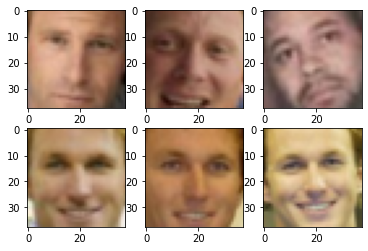

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)



```
# This is formatted as code
```

### Архитектура Автоэнкодера

Создадим автоэнкодер, который принимает на входд картинку, сжимает ее в боттленеке и восстанавливает изображение исходного размера
<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## 1 шаг: PCA - метод главных компонент - популярный способ снижения размерности данных, есть в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

Под капотом PCA делает разложение матрицы объекты-признаки в произведение двух матриц меньшего размера $W$ и $\hat W$ минимизируя _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - матрица признаков (**нормализованная**);
- $W \in \mathbb{R}^{m \times d}$ - матрица прямого преобразования;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - матрица обратного преобразования;
- $n$ объектов, $m$ признаков and $d$ желаемая размерность;

Геометрически, мы хотим найти d осей координат, вдоль которых данные наибольшим образом отличаются.


PCA также можно рассматривать как специальный случай Автоэнкодера.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X



In [ ]:
# this class corresponds to view-function and may be used as a reshape layer 

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

In [ ]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super().__init__()
        # Your code
         

    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [ ]:
def train(model, dataset, num_epoch=32):
    gd = optim.Adam(model.parameters(), lr=0.01)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        for i, (batch) in enumerate(dataloader):
            gd.zero_grad()
            reconstruction = model(batch)
            loss = torch.mean((batch - reconstruction)**2)
            loss.backward()
            losses.append(loss.detach().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [ ]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img[None])
    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.data.numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.data.numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].data.numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [35]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, 40)

#1, Train loss: 1.2140960
#2, Train loss: 0.6203335
#3, Train loss: 0.4289615


KeyboardInterrupt: ignored

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc(batch).data.numpy())
print (np.mean(scores))

In [ ]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)


### Going deeper

PCA - хорошо, но можно сделать лучше! Stack more layers!

А именно, пксть ваши encoder и decoder будут как минимум 3 слоя каждый (не считая батч норм и активацию!). 

Замечание:
* Не должно быть слоев меньшего размера чем боттленек (encoder output).
* После того, как получится полносвязный, попробуйте полносверточный автоэнкодер
* Можно использовать активацию в боттлнеке, но на самом деле необязательно.

In [ ]:
class pca_autoencoder_deep(nn.Module):
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep, self).__init__()
        # your code

In [ ]:
aenc_deep = pca_autoencoder_deep()

In [ ]:
train(aenc_deep, X_train_tensor, 100)

#1, Train loss: 0.0954943
#2, Train loss: 0.0515008
#3, Train loss: 0.0365538
#4, Train loss: 0.0290398
#5, Train loss: 0.0245071
#6, Train loss: 0.0214653
#7, Train loss: 0.0192878
#8, Train loss: 0.0176522
#9, Train loss: 0.0163709
#10, Train loss: 0.0153429
#11, Train loss: 0.0145029
#12, Train loss: 0.0137956
#13, Train loss: 0.0131976
#14, Train loss: 0.0126839
#15, Train loss: 0.0122360
#16, Train loss: 0.0118461
#17, Train loss: 0.0114989
#18, Train loss: 0.0111907
#19, Train loss: 0.0109119
#20, Train loss: 0.0106590
#21, Train loss: 0.0104313
#22, Train loss: 0.0102238
#23, Train loss: 0.0100348
#24, Train loss: 0.0098598
#25, Train loss: 0.0096972
#26, Train loss: 0.0095462
#27, Train loss: 0.0094062
#28, Train loss: 0.0092747
#29, Train loss: 0.0091539
#30, Train loss: 0.0090386
#31, Train loss: 0.0089312
#32, Train loss: 0.0088296
#33, Train loss: 0.0087337
#34, Train loss: 0.0086443
#35, Train loss: 0.0085590
#36, Train loss: 0.0084786
#37, Train loss: 0.0084023
#38, Train

Training may take long, it's okay.

In [ ]:
train(aenc_deep, X_train_tensor, 30)

**Check autoencoder shapes along different code_sizes. Check architecture of you encoder-decoder network is correct**

In [ ]:
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = pca_autoencoder_deep(code_size)
    encoder_out = model.enc(help_tensor.type('torch.FloatTensor'))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    assert (len(list(model.dec.children())) >= 6),  "decoder must contain at least 3 dense layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


** Попробуй получить лосс 0.007 **

In [ ]:
import matplotlib.pyplot as plt

Final MSE: 0.0049607273179098415


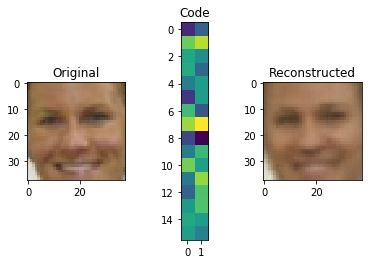

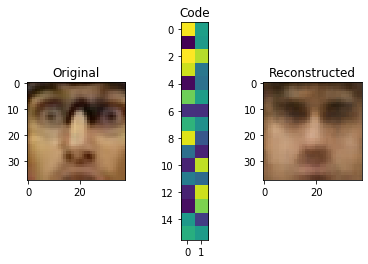

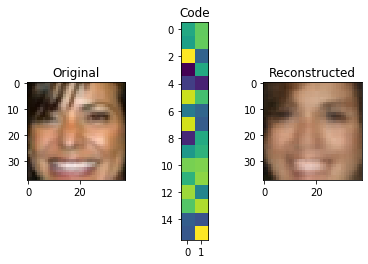

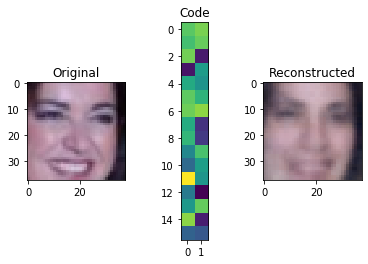

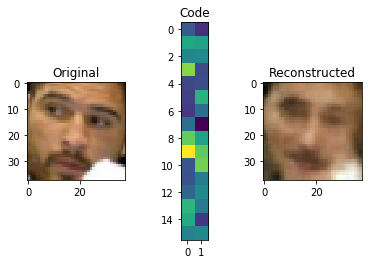

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    aenc_deep.train(False)
    scores.append(aenc_deep.batch_loss(batch(device = device)).data.numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.007, "Compression is too lossy. See tips below."
assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

## Denoising AutoEncoder

Используем построенную модель, но обучим ее на других данных - на входное изобрадение случайный шум.

In [ ]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = # your code
    return X + noise

**Протестируй**

In [ ]:
apply_gaussian_noise(X[:1],sigma=0.01).dtype

dtype('float32')

In [ ]:
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose((1,2,0)).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose((1,2,0)).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose((1,2,0)).clip(0, 1))

In [ ]:
#<Your code: define train function for denoising autoencoder as train function above>
def train_noise(model, dataset, num_epoch=50):
    model.double()
    model.to(device)
    gd = optim.Adam(model.parameters(), lr=0.001)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        for i, (batch) in enumerate(dataloader):
            gd.zero_grad()
            batch = batch.type(torch.DoubleTensor)
            noisy_batch = # your code
            reconstruction =  # your code

            loss = #your code
            (loss).backward()
            losses.append(loss.data.numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [ ]:
X_train_noise = apply_gaussian_noise(X_train)
X_test_noise = apply_gaussian_noise(X_test)

In [ ]:
X_train_tensor_n = torch.tensor(X_train_noise, dtype=torch.float32)
X_test_tensor_n = torch.tensor(X_test_noise, dtype=torch.float32)

In [ ]:
aenc = pca_autoencoder()
train_noise(aenc, X_train, 50)

#1, Train loss: 0.0689766
#2, Train loss: 0.0448610
#3, Train loss: 0.0362919
#4, Train loss: 0.0313106
#5, Train loss: 0.0280182
#6, Train loss: 0.0255771
#7, Train loss: 0.0236906
#8, Train loss: 0.0221793
#9, Train loss: 0.0208900
#10, Train loss: 0.0198241
#11, Train loss: 0.0188885
#12, Train loss: 0.0180712
#13, Train loss: 0.0173345
#14, Train loss: 0.0166901
#15, Train loss: 0.0161052
#16, Train loss: 0.0155722
#17, Train loss: 0.0150840
#18, Train loss: 0.0146381
#19, Train loss: 0.0142314
#20, Train loss: 0.0138591
#21, Train loss: 0.0135176
#22, Train loss: 0.0131963
#23, Train loss: 0.0128973
#24, Train loss: 0.0126161
#25, Train loss: 0.0123557
#26, Train loss: 0.0121165
#27, Train loss: 0.0118872
#28, Train loss: 0.0116734
#29, Train loss: 0.0114760
#30, Train loss: 0.0112877
#31, Train loss: 0.0111125
#32, Train loss: 0.0109468
#33, Train loss: 0.0107907
#34, Train loss: 0.0106429
#35, Train loss: 0.0105034
#36, Train loss: 0.0103725
#37, Train loss: 0.0102466
#38, Train


__Bonus:__ Замени нормальный шум на вырезание случайных прямоугольников из картинки.

In [ ]:
dataloader_test = DataLoader(X_test_tensor_n, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch).data.numpy())
    encoder_out = aenc.enc(batch)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor_n[i]
    visualize(img,aenc)